**GW25_PFCUL**

# Libraries

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.21.1 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [12]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/GW25_04_20240216_v1.h5ad'  # the file that will store the analysis results

In [13]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [14]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/GW25_PFCUL/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-GW25_PFCUL-matrix.h5ad


In [15]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [16]:
adata

AnnData object with n_obs × n_vars = 3839 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


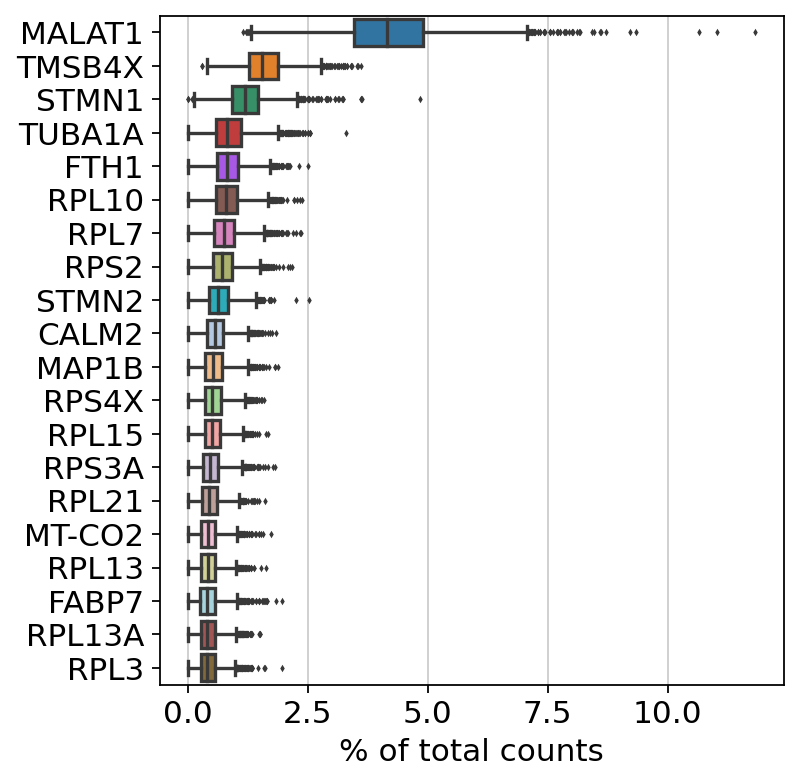

In [17]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 25780 genes that are detected in less than 50 cells


In [19]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

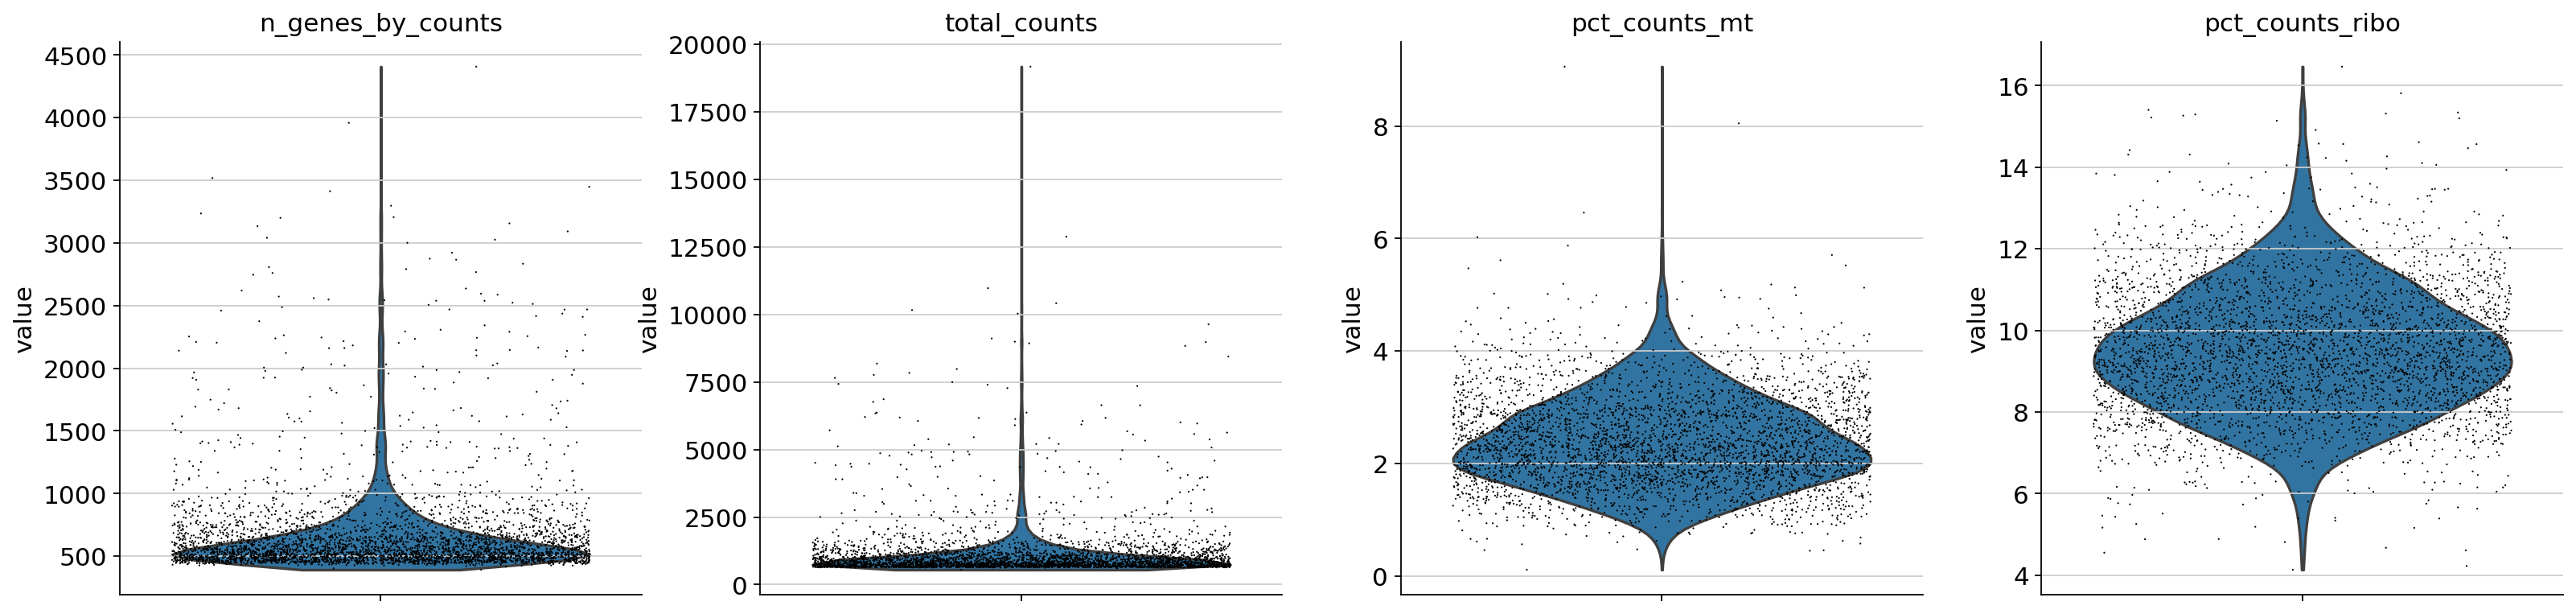

In [20]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

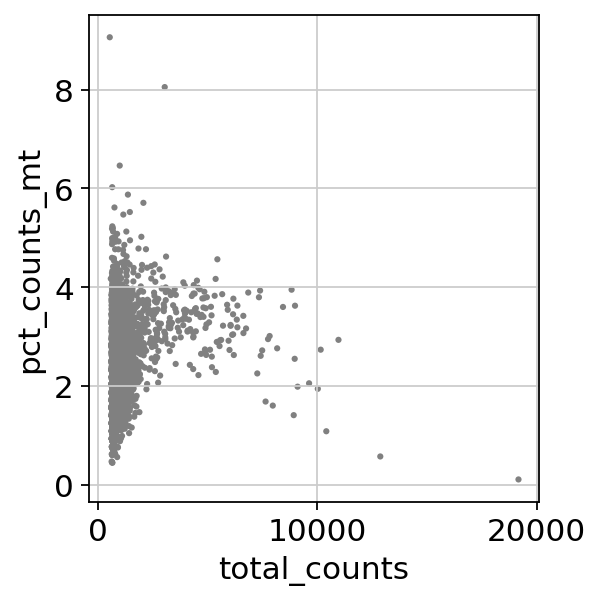

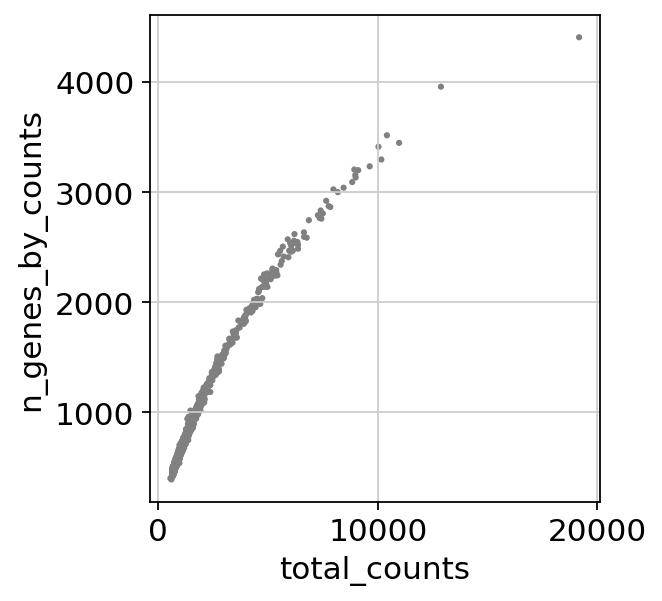

In [21]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [22]:
adata = adata[adata.obs.total_counts <= 5000]

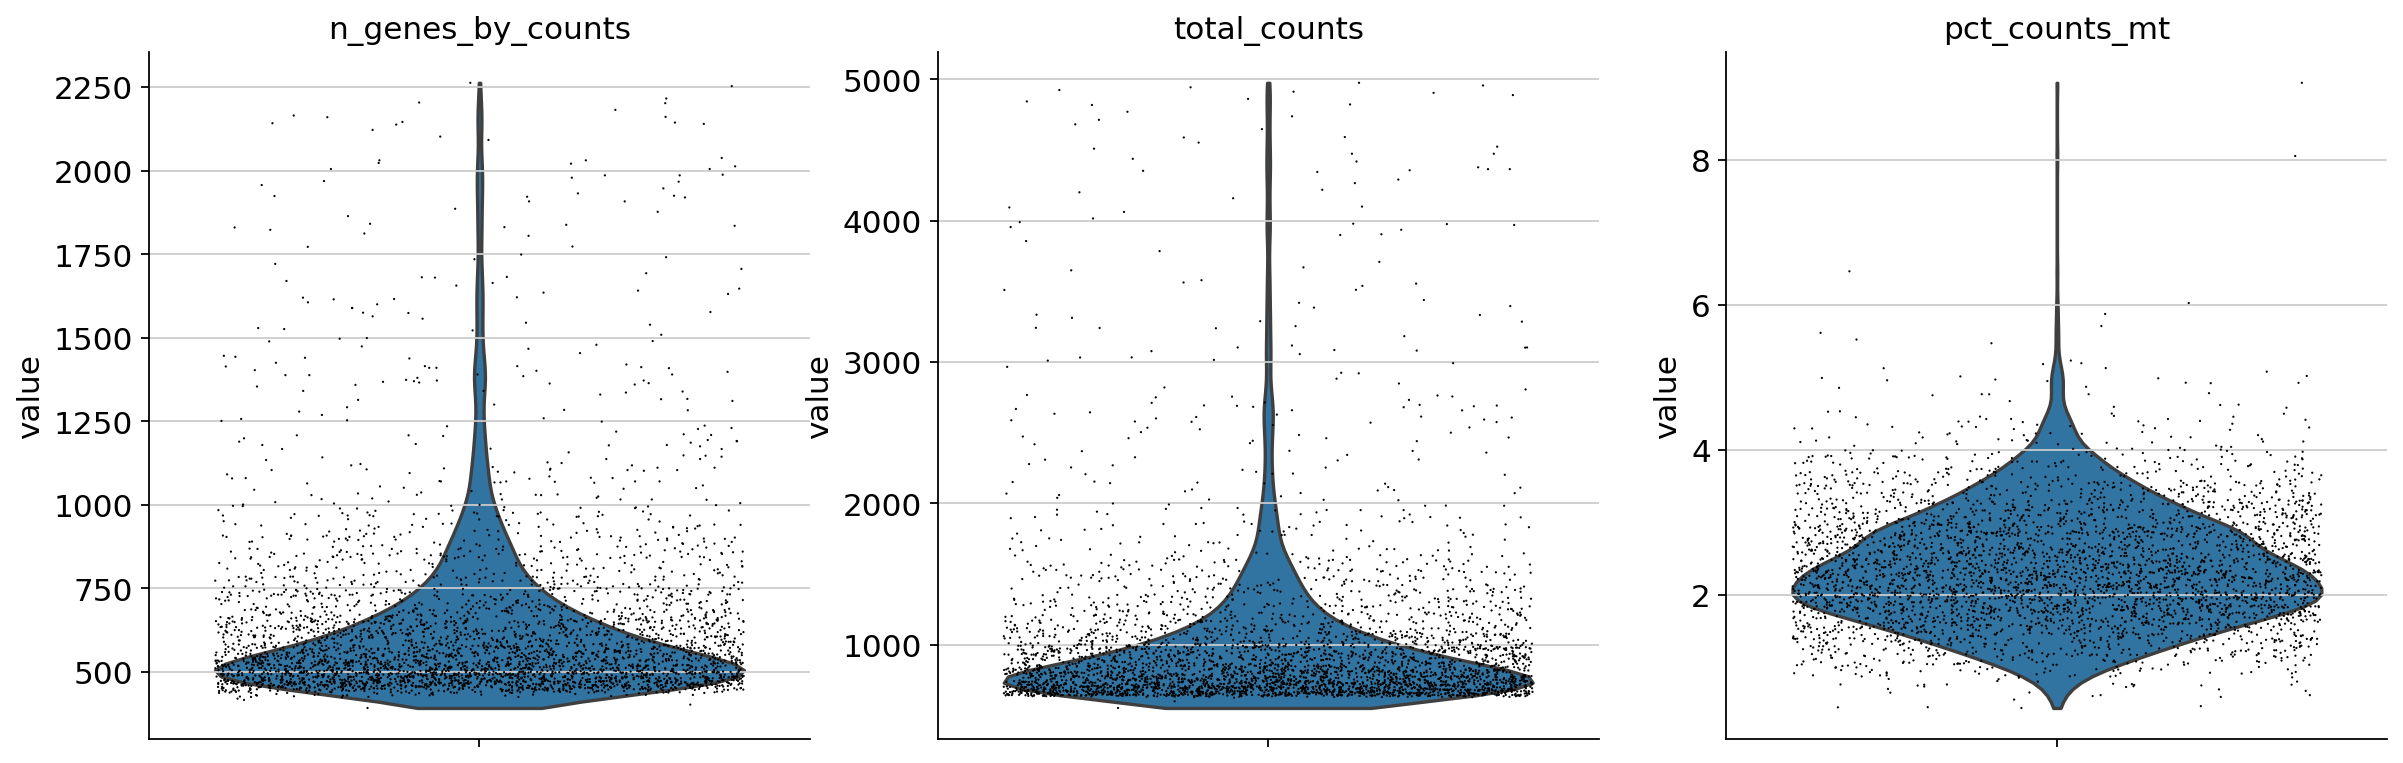

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [24]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'S_score', score of gene set (adata.obs).
    428 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    601 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [25]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [26]:
adata.obs.phase.value_counts()

G1     2012
S      1216
G2M     554
Name: phase, dtype: int64

In [27]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 31.6%
    Scrublet finished (0:00:03)


In [28]:
adata.obs.predicted_doublet.value_counts()

False    3779
True        3
Name: predicted_doublet, dtype: int64

In [29]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=5000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [30]:
adata

AnnData object with n_obs × n_vars = 3782 × 7914
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [31]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


Index(['SPARC', 'RC3H2', 'HNRNPH1', 'BRPF3', 'PAK7', 'SLC38A1', 'TCF20',
       'FAM20B', 'SOX11', 'GRIP1', 'RP11-258C19.7', 'MPP6', 'SGIP1', 'SYT13',
       'MYO9A', 'PPP3CA', 'DYRK2', 'HDAC4', 'ITPR1', 'GRIN2B'],
      dtype='object')

In [32]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['SLC35E2B', 'GNB1', 'CAMTA1', 'KIF1B', 'TARDBP', 'MTOR', 'SPEN',
       'EPHB2', 'RCAN3', 'PAQR7',
       ...
       'U2AF1', 'AGPAT3', 'LINC00205', 'DIP2A', 'MT-ND1', 'MT-ND2', 'MT-CO1',
       'MT-ATP6', 'MT-ND4', 'MT-CYB'],
      dtype='object', length=1300)

# Principle Component Analysis

In [33]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


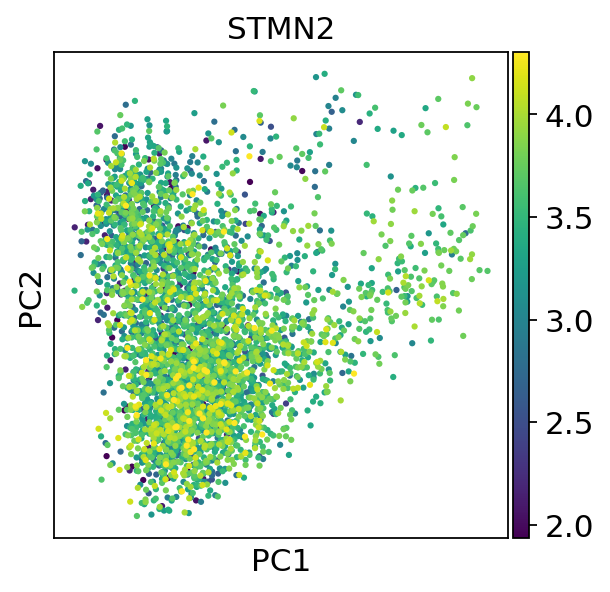

In [34]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['STMN2'],use_raw=False,vmin="p1",vmax="p99") 

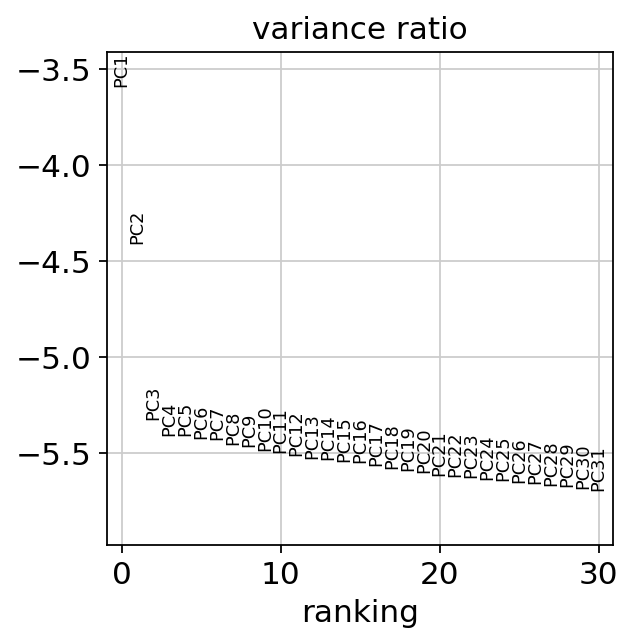

In [35]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
# saving the result
adata.write(results_file)

In [37]:
adata

AnnData object with n_obs × n_vars = 3782 × 7914
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [38]:
int(0.5 * len(adata) ** 0.5)

30

In [39]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding Neighborhood Graph

In [40]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [41]:
adata.obs.leiden.value_counts()

0    1510
1    1120
2     976
3     176
Name: leiden, dtype: int64

In [42]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [43]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


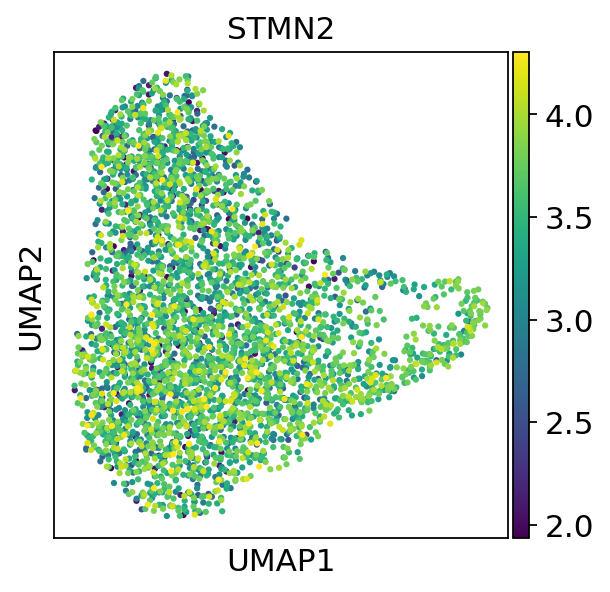

In [44]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

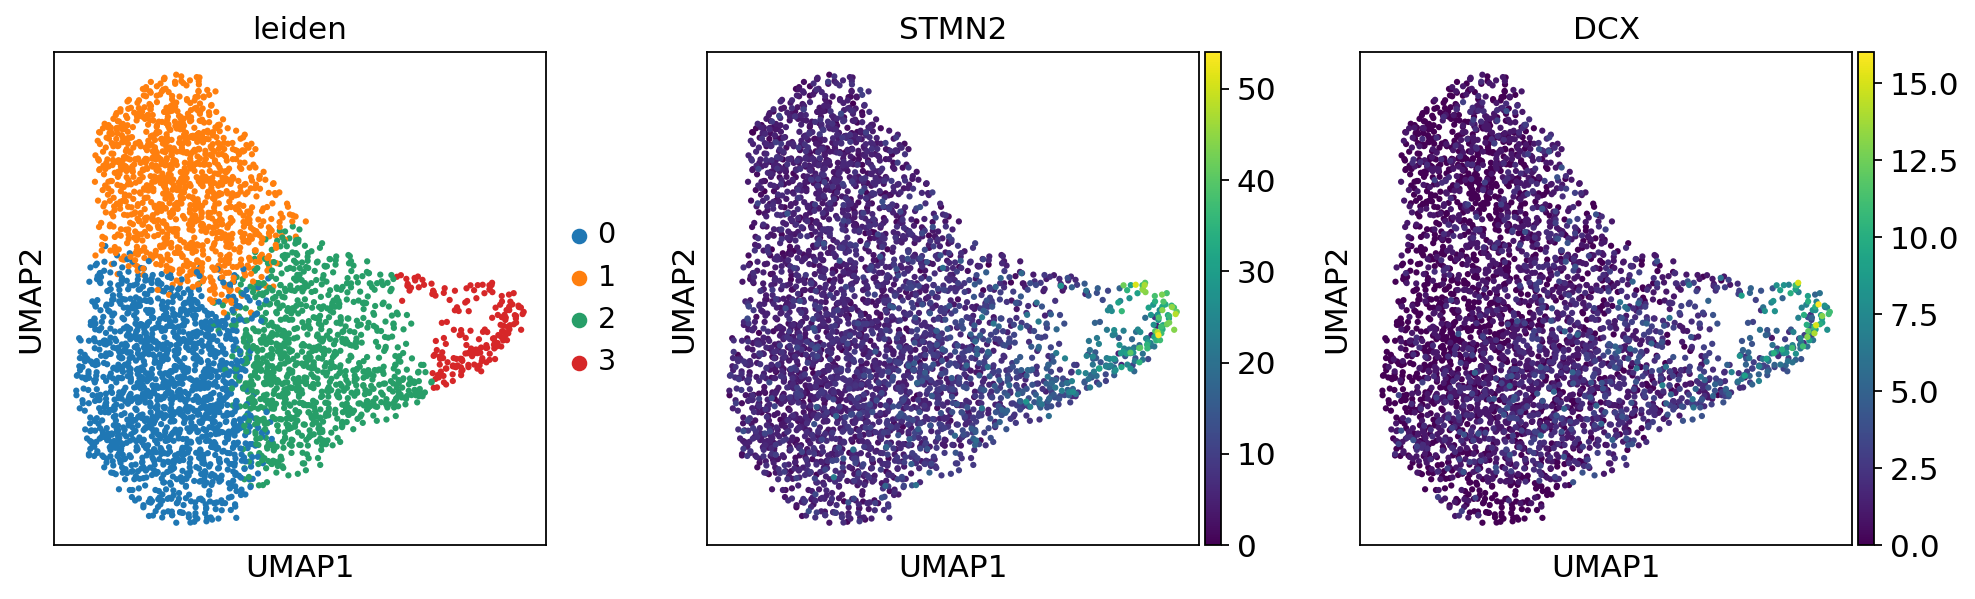

In [46]:
sc.pl.umap(adata, color=['leiden','STMN2', 'DCX'])

In [47]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


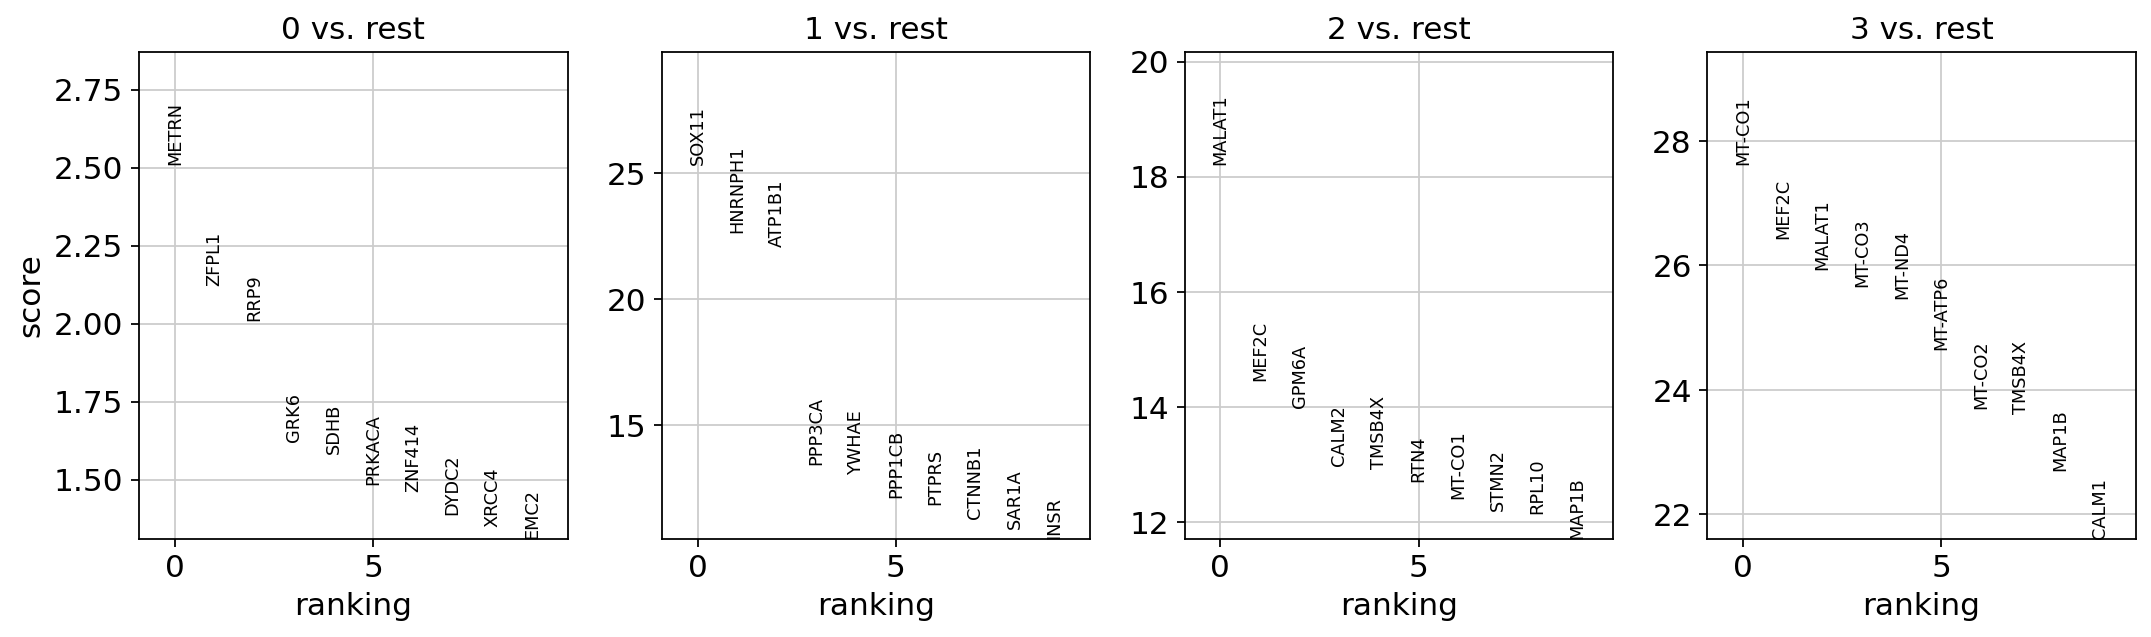

In [48]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [49]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n       0_p      1_n            1_p     2_n           2_p     3_n  \
0  METRN  0.012116    SOX11  2.668611e-124  MALAT1  6.690139e-70  MT-CO1   
1  ZFPL1  0.034050  HNRNPH1   1.897330e-99   MEF2C  1.674379e-45   MEF2C   
2   RRP9  0.044495   ATP1B1   3.903992e-98   GPM6A  1.474045e-42  MALAT1   
3   GRK6  0.105329   PPP3CA   3.381834e-39   CALM2  6.141955e-37  MT-CO3   
4   SDHB  0.113232    YWHAE   1.902859e-37  TMSB4X  7.827241e-37  MT-ND4   

            3_p  
0  3.803450e-66  
1  1.938392e-63  
2  3.166434e-62  
3  1.340948e-61  
4  4.533811e-61

In [50]:
adata.write(results_file)

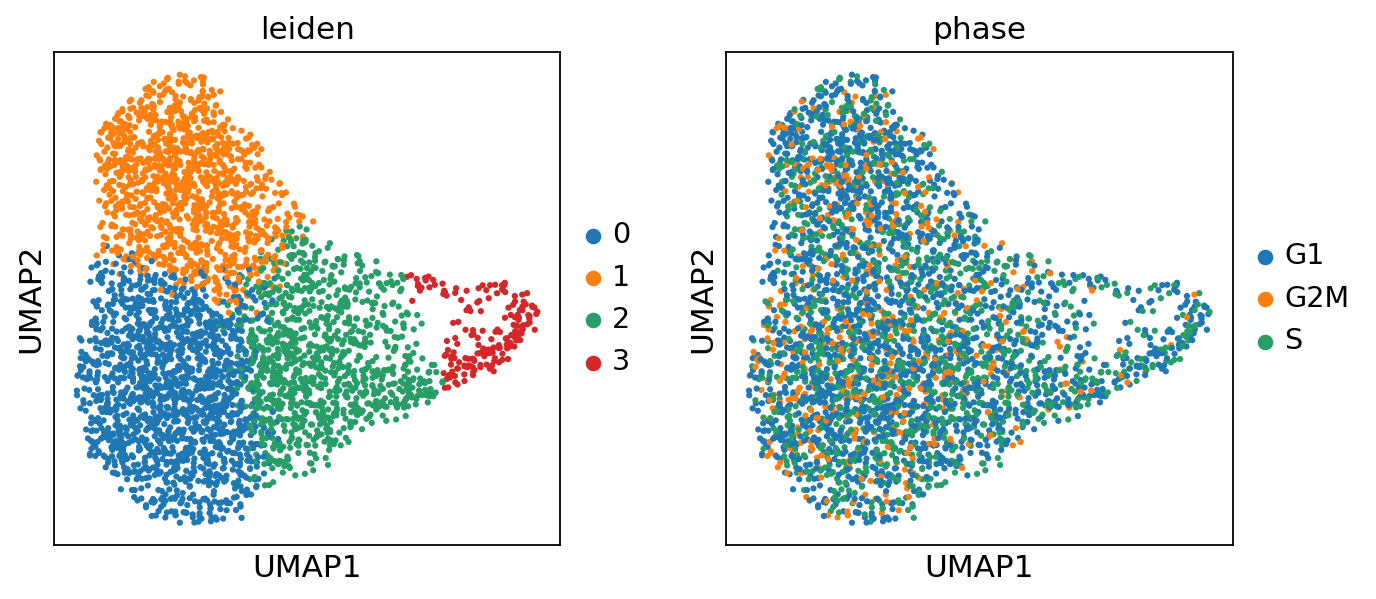

In [51]:
sc.pl.umap(adata,color=["leiden","phase"])

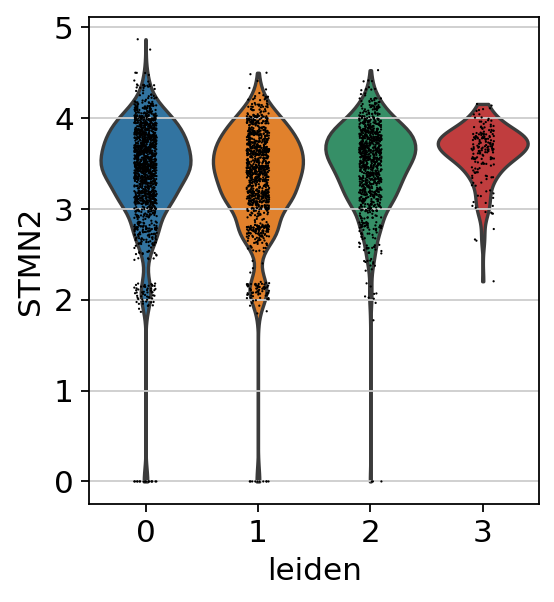

In [52]:
sc.pl.violin(adata, ['STMN2'], groupby='leiden',use_raw=False)

In [53]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1       2        3
0   METRN    SOX11  MALAT1   MT-CO1
1   ZFPL1  HNRNPH1   MEF2C    MEF2C
2    RRP9   ATP1B1   GPM6A   MALAT1
3    GRK6   PPP3CA   CALM2   MT-CO3
4    SDHB    YWHAE  TMSB4X   MT-ND4
5  PRKACA   PPP1CB    RTN4  MT-ATP6
6  ZNF414    PTPRS  MT-CO1   MT-CO2
7   DYDC2   CTNNB1   STMN2   TMSB4X
8   XRCC4    SAR1A   RPL10    MAP1B
9    EMC2     INSR   MAP1B    CALM1

In [54]:
marker_genes = ['leiden','SOX11','HNRNPH1', 'CORO1A', 'METRN', 'MALAT1', 'MEF2C', 'CCNI', 'DPYSL2', 'MT-ND2', 'MALAT1', 'MEF2C' ]

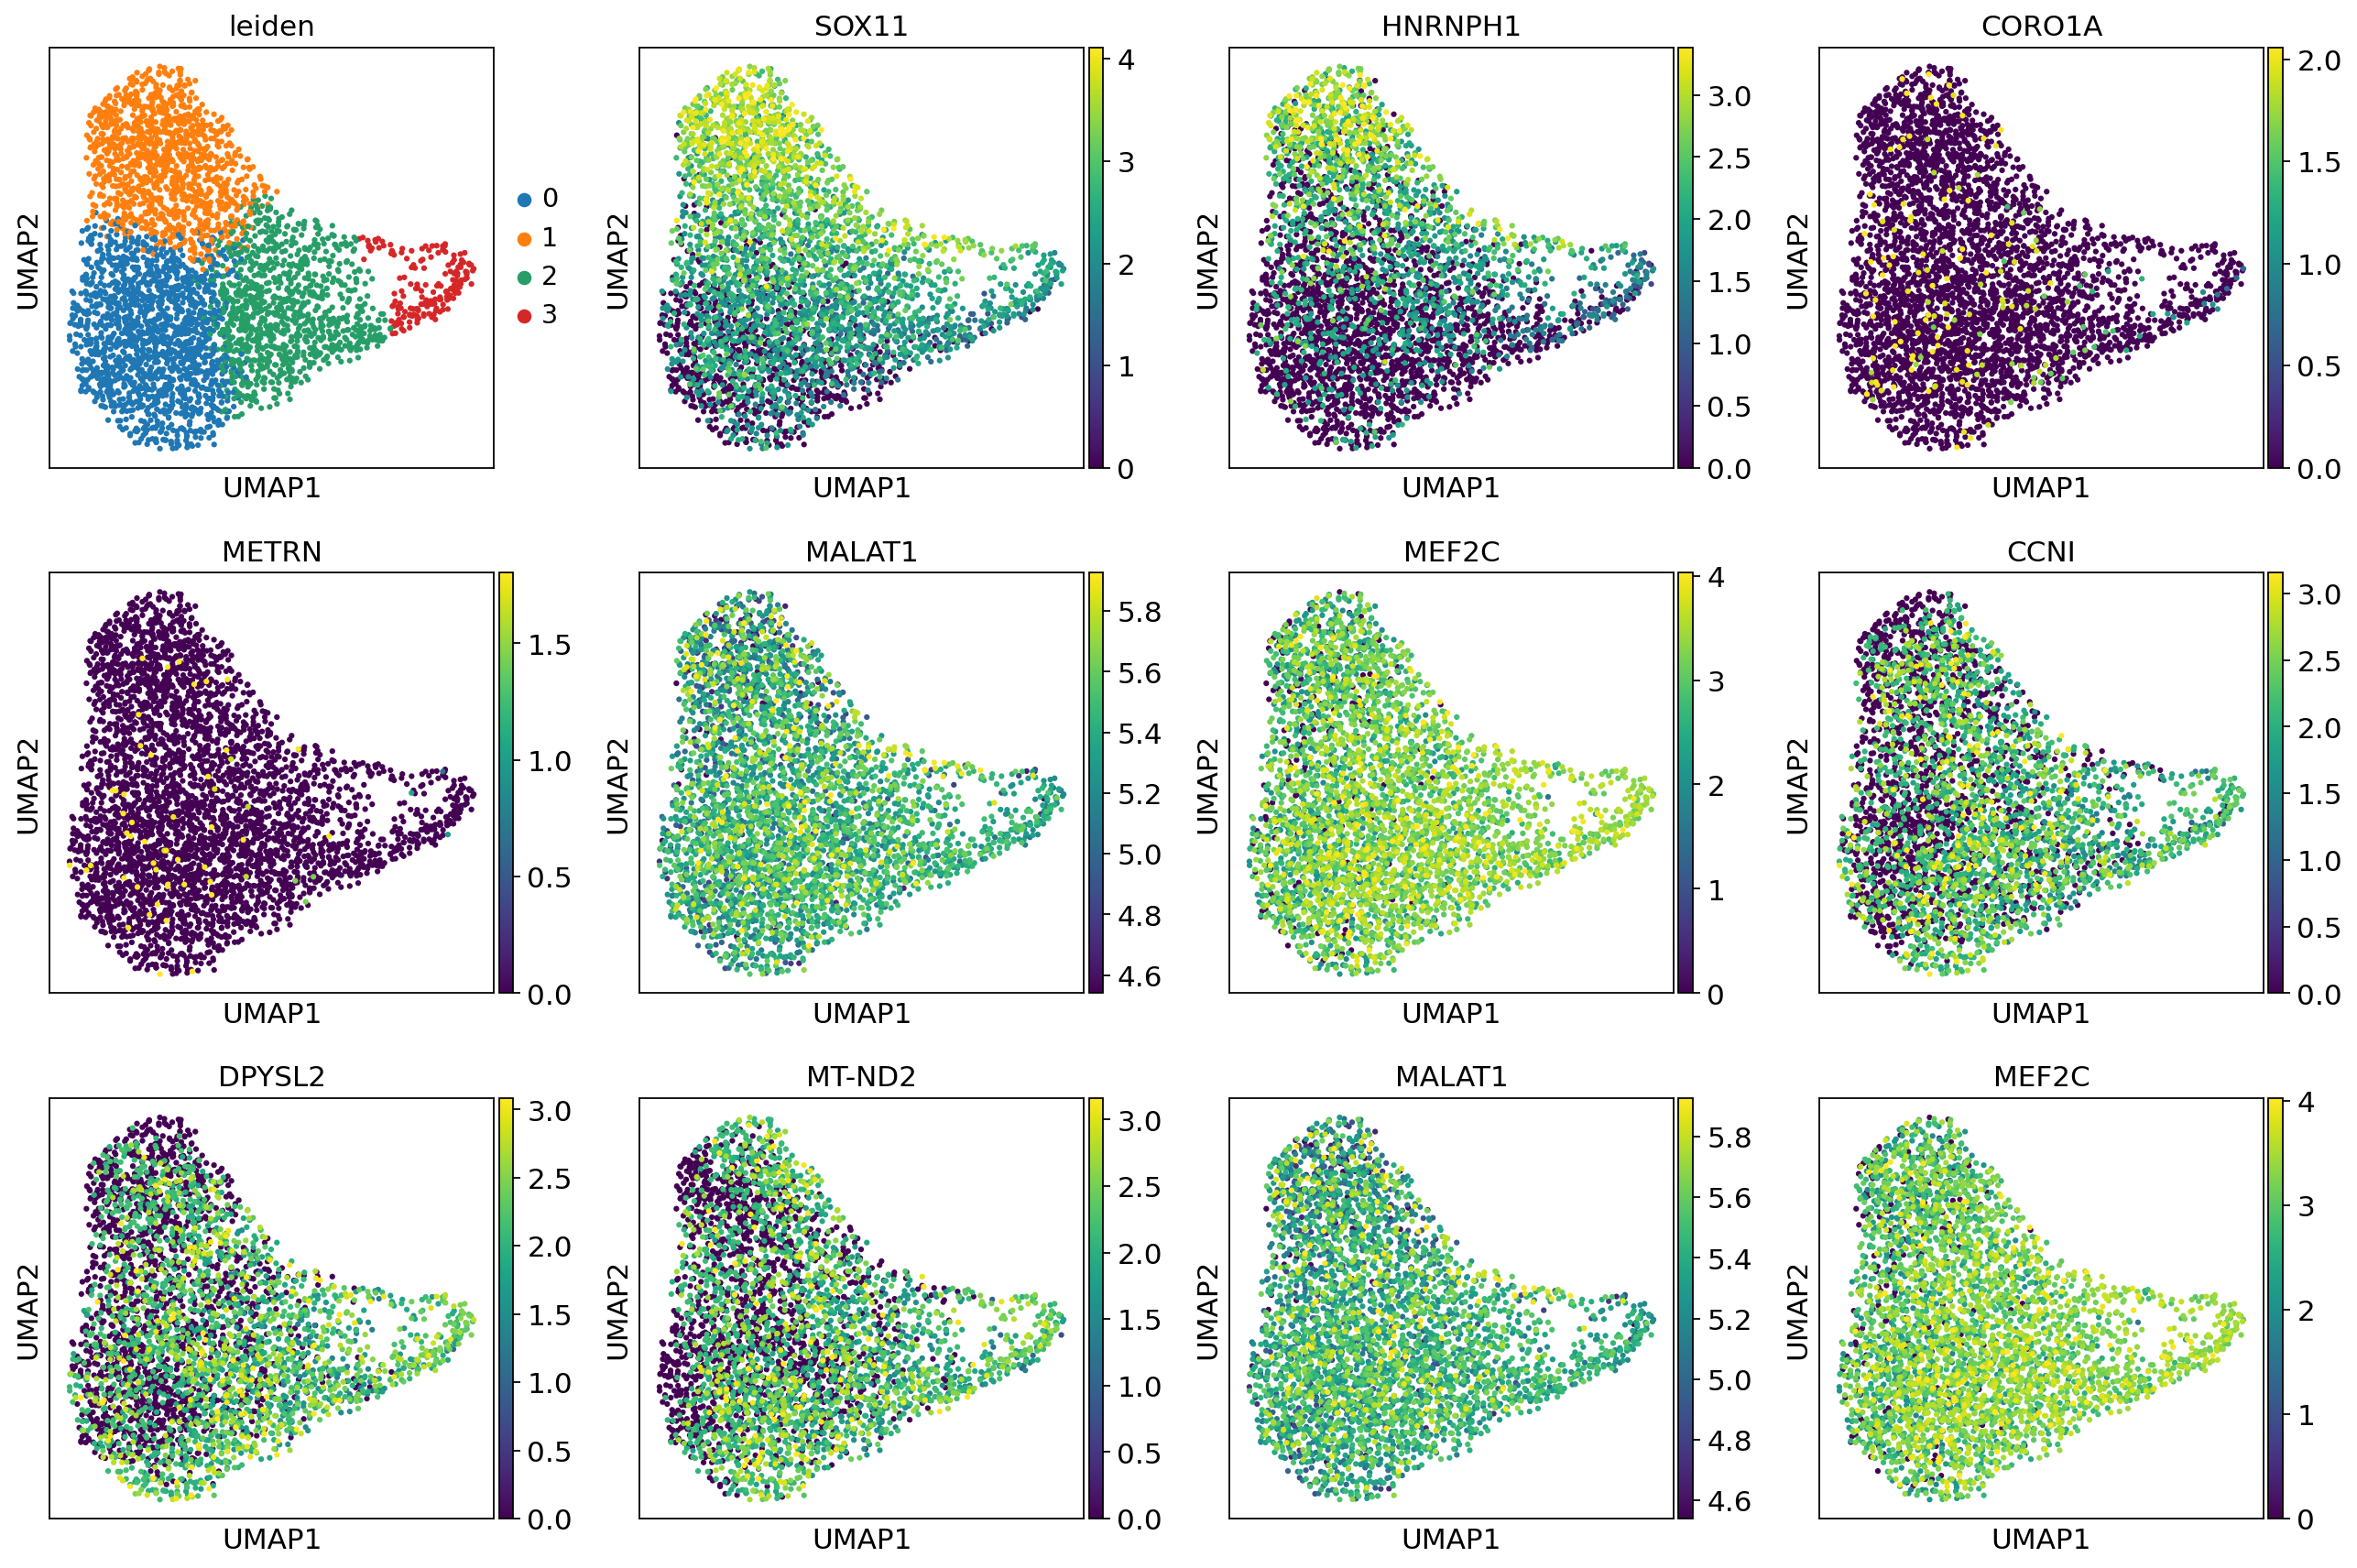

In [55]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [56]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9824406  0.941429   0.92227584 0.8846829  0.8643476
     0.8295913  0.81682616 0.812679   0.8117601  0.8069604  0.80369633
     0.79341936 0.7895769  0.78806585]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


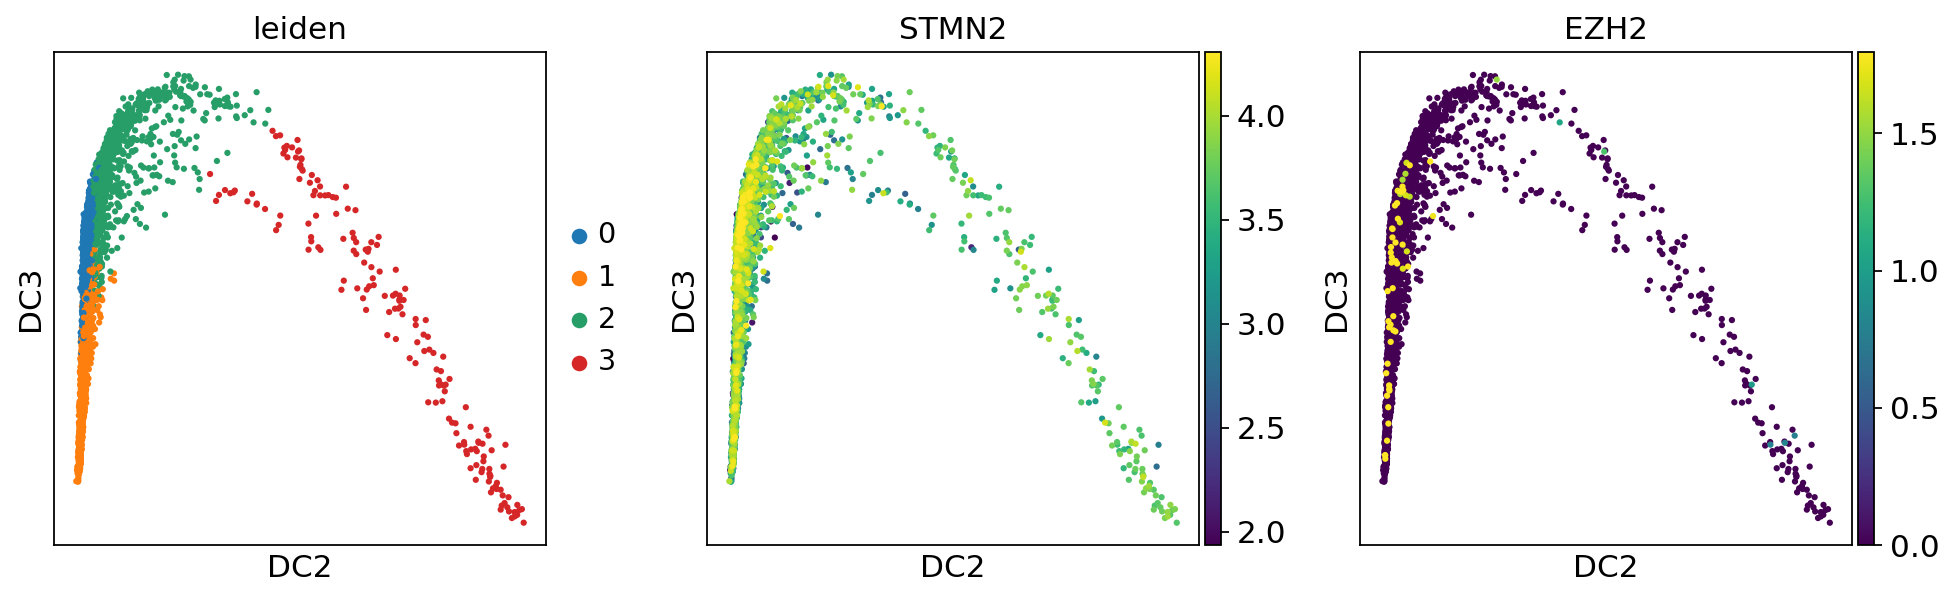

In [59]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [60]:
#adata_check = adata[~adata.obs.leiden.isin(['7'])].copy()

In [61]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: endothelial, ExcDeepLayer, Interneurons, etc.


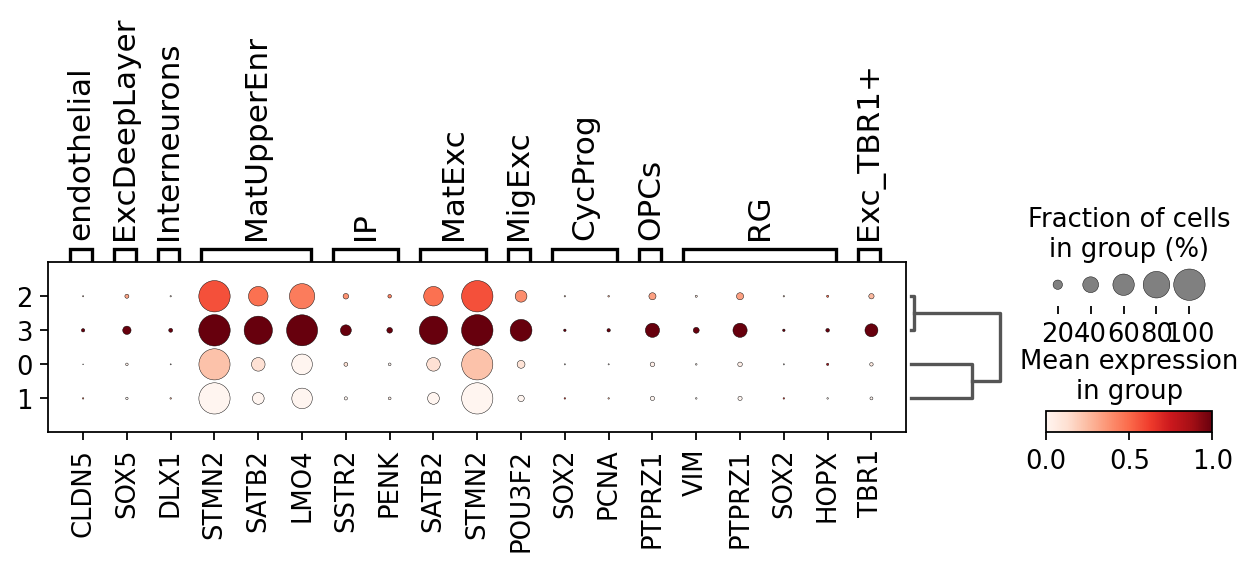

In [62]:
geschwind_ext = {
  'endothelial' : ['CLDN5'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['SSTR2','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['SOX2','PCNA'],
  'OPCs' : ['PTPRZ1'],
  'RG' : ['VIM','PTPRZ1','SOX2','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [63]:
# GENERAL ONE
cluster2annotation = {
     "0": "Neu", "1": "Neu","2":"Neu", "3": "Neu"
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [64]:
# SPECIFIC 

cluster2annotation = {
     "0": "Mig/Mat", "1": "MatExc","2":"Mig/Mat", "3": "DeepLayer"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [65]:
new_cluster_names = [
    '0/Mig/Mat', '1/MatExc',
    '2/Mig/Mat', '3/DeepLayer']
adata.rename_categories('leiden', new_cluster_names)

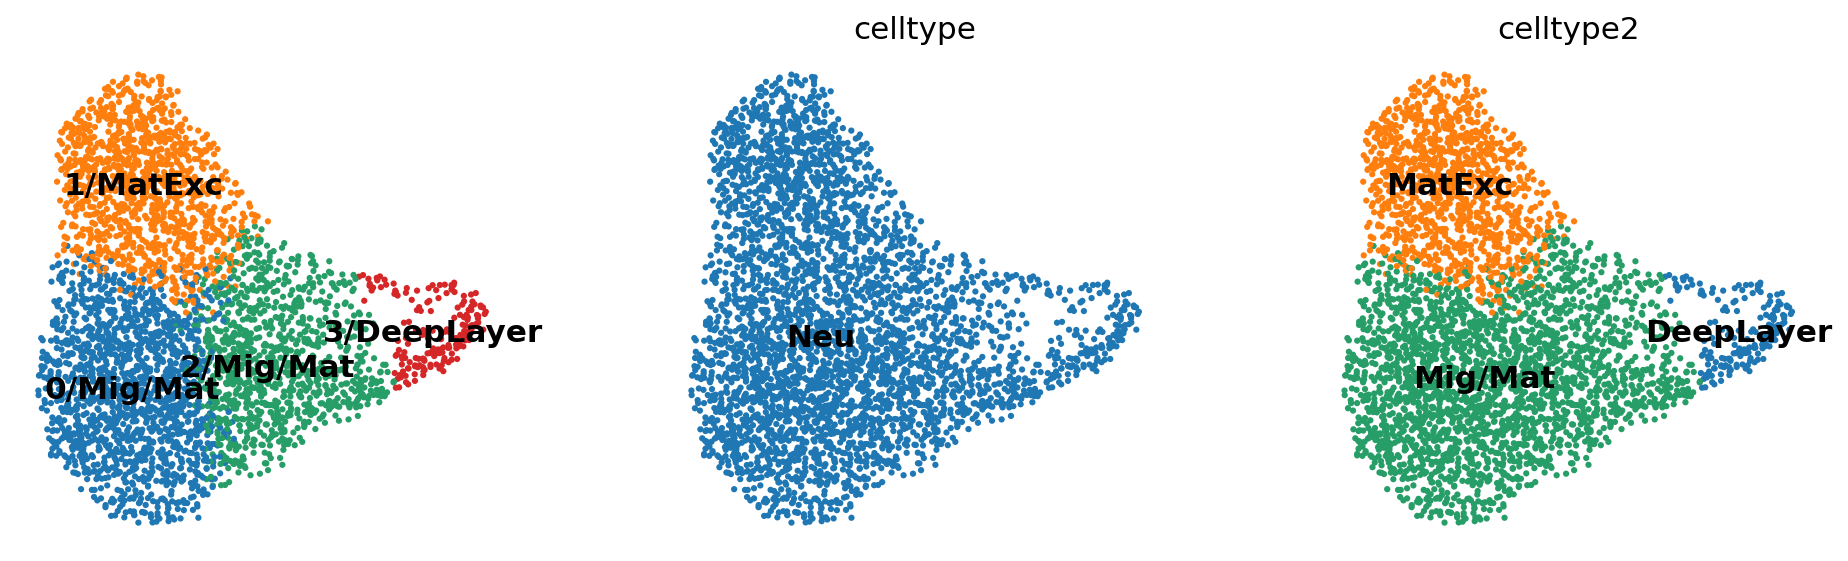

In [66]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

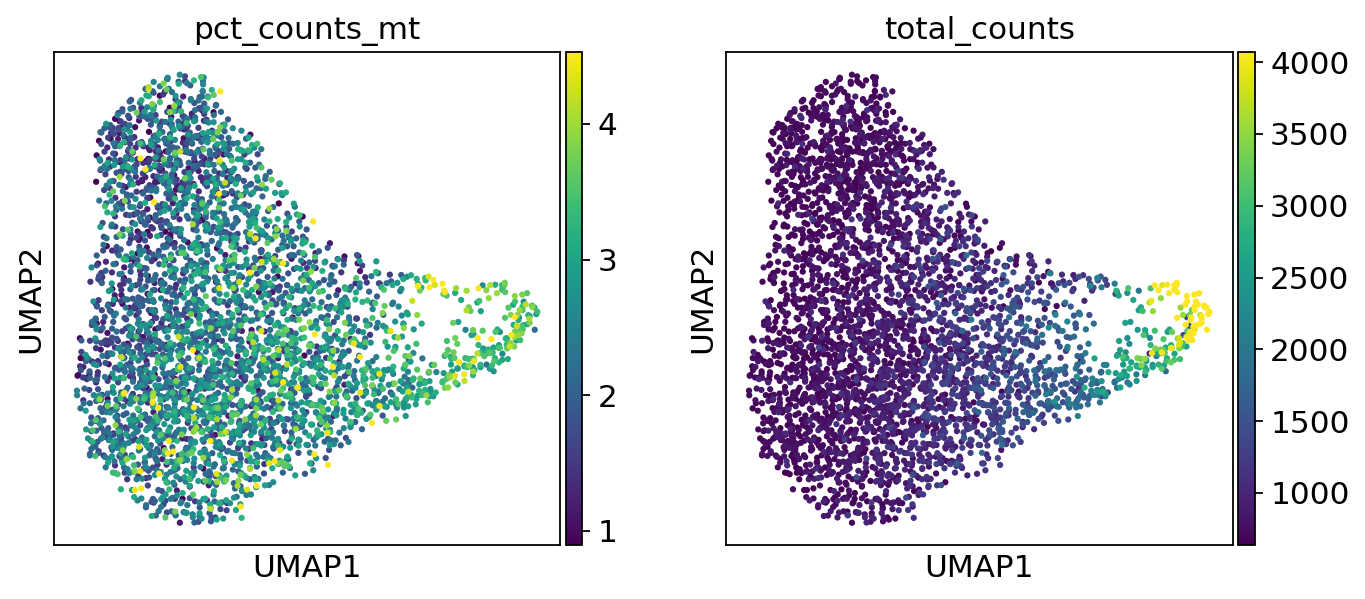

In [67]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [68]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [69]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9824406  0.941429   0.92227584 0.8846829  0.8643476
     0.8295913  0.81682616 0.812679   0.8117601  0.8069604  0.80369633
     0.79341936 0.7895769  0.78806585]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [70]:
adata.obs.leiden.value_counts()

0/Mig/Mat      1510
1/MatExc       1120
2/Mig/Mat       976
3/DeepLayer     176
Name: leiden, dtype: int64

In [71]:
#adata_check = adata[~adata.obs.celltype.isin(['pericyte', 'astrocyte'])].copy()

In [72]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9824406  0.941429   0.92227584 0.8846829  0.8643476
     0.8295913  0.81682616 0.812679   0.8117601  0.8069604  0.80369633
     0.79341936 0.7895769  0.78806585]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


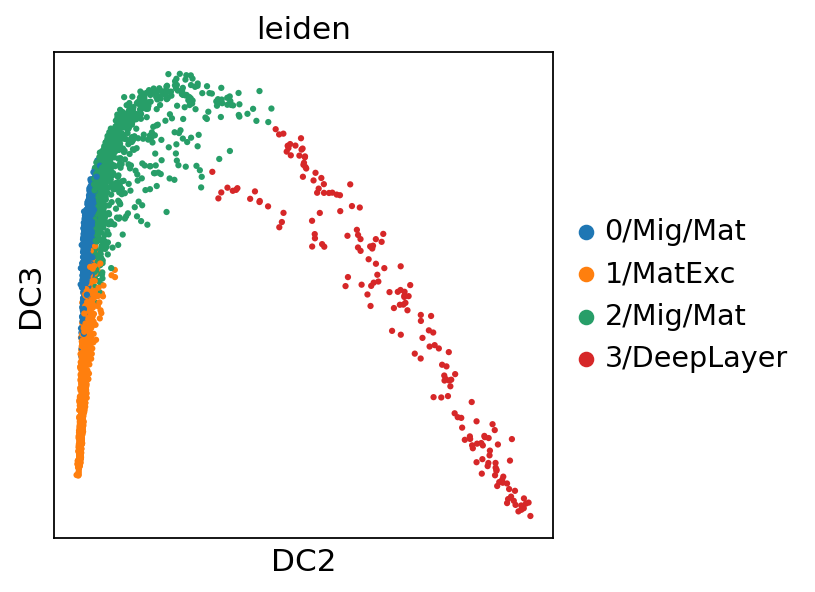

In [73]:
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [74]:
adata.obs.leiden

AAACCTGAGCAGATCG-1    0/Mig/Mat
AAACCTGAGCCATCGC-1    2/Mig/Mat
AAACCTGCAGGTGGAT-1    0/Mig/Mat
AAACCTGGTGTTGAGG-1    0/Mig/Mat
AAACGGGAGACCACGA-1    2/Mig/Mat
                        ...    
TTTGTCAAGTACGATA-1     1/MatExc
TTTGTCAGTCAGCTAT-1    0/Mig/Mat
TTTGTCATCCATGAAC-1     1/MatExc
TTTGTCATCTAACGGT-1     1/MatExc
TTTGTCATCTCCCTGA-1    0/Mig/Mat
Name: leiden, Length: 3782, dtype: category
Categories (4, object): ['0/Mig/Mat', '1/MatExc', '2/Mig/Mat', '3/DeepLayer']

In [75]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW25_04_20240216_v1.h5ad")

In [8]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW25_04_20240216_v1.h5ad")

In [9]:
adata.obs['stage'] = 'GW25'

In [10]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/GW25_04_20240216_v1.h5ad')